# Simulation plots

In [1]:
import numpy as np
import h5py
import re
import swiftsimio as sw
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
centers = pd.read_csv('centers.txt', names = ['vol_num','X','Y','Z'], index_col=0)

In [12]:
#_i is always index from the catalogue, 
#and _ids is id from the catalogue
class SimTools():
    def __init__(self, catalogue, snapshot, membership_file, siminfo_file, volume_num):
        self.catalogue_file = catalogue
        self.snapshot = snapshot
        self.membership_file = membership_file
        self.siminfo_file = siminfo_file
        self.mstar = None
        self.mtotal = None
        self.soap = h5py.File(self.catalogue_file, 'r') # Read in SOAP property file
        self.field = np.array(self.soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
        self.vol = volume_num
        self.halo_ids = self.soap['VR/ID']
        self.host_halo_ids = np.array(self.soap['VR/ID'])[self.field==-1]
        self.host_halo_i = np.array(self.host_halo_ids)-1
        
        with open(self.siminfo_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if 'h_val' in line:
                parts = line.split()
                self.h_val = float(parts[2])
                break
        
    def getHaloMasses(self):
        self.mtotal = np.array(self.soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
        try:
            self.mstar = np.array(self.soap['ExclusiveSphere/30kpc/StellarMass'])
        except KeyError:
            print('looking somewhere else')
            self.mtotal = np.array(self.soap['BoundSubhaloProperties/StellarMass'])

        return self.mtotal, self.mstar

    def getHaloDarkMatterMembers(self, halo_i):
        #halo INDEX is not halo ID
        # function to read in bound DM particles for a given halo
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType1/GroupNr_bound'])
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.positions

    def getHaloStarsMembers(self, halo_i):
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.star_positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.star_positions
    
    def calc_r200(self, host_i):
        m200 = np.array(self.soap['SO/200_crit/TotalMass'])[host_i] #mass is in solar mass
        
        H = self.h_val*100 #converting from H/100 to h
        G = 4.3e-9 #converting from pc to Mpc
        rho_crit = 3*(H**2)/(8*np.pi*G)
        r200 = (m200/(4/3. * np.pi * 200*rho_crit))**(1/3)*1000
        return r200
            
    def make_volume_table(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        
        host_r200 = [self.calc_r200(i) for i in range(len(self.host_halo_i))]
        host_CoM = self.soap['BoundSubhaloProperties/CentreOfMass'][self.host_halo_i].tolist()
        host_tot_mass = [self.mtotal[i] for i in self.host_halo_i]
        host_stellar_mass = [self.mstar[i] for i in self.host_halo_i]
        #----new----
        host_corot = self.soap['ExclusiveSphere/30kpc/KappaCorotStars'][self.host_halo_i].tolist()
        host_atomicH = self.soap['ExclusiveSphere/30kpc/AtomicHydrogenMass'][self.host_halo_i].tolist()
        host_gasM = self.soap['BoundSubhaloProperties/GasMass'][self.host_halo_i].tolist()
        host_halfM_radius = self.soap['ExclusiveSphere/30kpc/HalfMassRadiusStars'][self.host_halo_i].tolist()
        host_metalfrac = self.soap['ExclusiveSphere/30kpc/StellarMassFractionInMetals'][self.host_halo_i].tolist()
        host_ironfrac = self.soap['ExclusiveSphere/30kpc/StellarMassFractionInIron'][self.host_halo_i].tolist()
        host_vel_dispersion = self.soap['ExclusiveSphere/30kpc/StellarVelocityDispersionMatrix'][self.host_halo_i].tolist()
        #-------------
        sat_ids = [self.halo_ids[self.field == i].tolist() for i in self.host_halo_ids]
        sat_i = [(np.array(ids) - 1).tolist() for ids in sat_ids]
        sat_CoM = []
        sat_tot_mass = []
        sat_stellar_mass = []
        #---new---
        sat_atomicH = []
        sat_gasM = []
        sat_halfM_radius = []
        sat_metalfrac = []
        sat_ironfrac = []
        sat_vel_dispersion = []
        #---------
        for i in sat_i:
            sat_CoM.append(self.soap['BoundSubhaloProperties/CentreOfMass'][i].tolist())
            sat_tot_mass.append(self.mtotal[i].tolist())
            sat_stellar_mass.append(self.mstar[i].tolist())
            #---new---
            sat_atomicH.append(self.soap['ExclusiveSphere/30kpc/AtomicHydrogenMass'][i].tolist())
            sat_gasM.append(self.soap['BoundSubhaloProperties/GasMass'][i].tolist())
            sat_halfM_radius.append(self.soap['ExclusiveSphere/30kpc/HalfMassRadiusStars'][i].tolist())
            sat_metalfrac.append(self.soap['ExclusiveSphere/30kpc/StellarMassFractionInMetals'][i].tolist())
            sat_ironfrac.append(self.soap['ExclusiveSphere/30kpc/StellarMassFractionInIron'][i].tolist())
            sat_vel_dispersion.append(self.soap['ExclusiveSphere/30kpc/StellarVelocityDispersionMatrix'][i].tolist())
            #---------

        vol = [self.vol] * len(self.host_halo_i)


        data_dict = {
            'Volume': vol,
            'Host i': self.host_halo_i,
            'Host ID': self.host_halo_ids,
            'Host R200': host_r200,
            'Host CoM': host_CoM,
            'Host Mtot': host_tot_mass,
            'Host M*': host_stellar_mass,
            'Host KappaCorot':host_corot,
            'Host Mhyd': host_atomicH,
            'Host Mgas':host_gasM,
            'Host HalfM* radius':host_halfM_radius,
            'Host M* Metal':host_metalfrac,
            'Host M* Iron':host_ironfrac,
            'Host vel': host_vel_dispersion,
            'Sat i': sat_i,
            'Sat ID': sat_ids,
            'Sat CoM': sat_CoM,
            'Sat Mtot': sat_tot_mass,
            'Sat M*': sat_stellar_mass,
            'Sat Mhyd': sat_atomicH,
            'Sat Mgas':sat_gasM,
            'Sat HalfM* radius':sat_halfM_radius,
            'Sat M* Metal':sat_metalfrac,
            'Sat M* Iron':sat_ironfrac,
            'Sat vel': sat_vel_dispersion,
        }

        df = pd.DataFrame(data_dict)
        self.main_df = df

        filename = f"data/volume_number_{self.vol}.csv"
        self.main_df.to_csv(filename, index=False)
        
        return self.main_df
    
    #=============PLOTS===============
    def plotBoxParticleDistribution(self):
        data = sw.load(self.snapshot) #read final snapshot
        pos = data.dark_matter.coordinates
        plt.figure(dpi=200)
        plt.plot(pos[::10,0], pos[::10,2],'k.', markersize=0.25, alpha=0.01)
        side_length = 0.20
        center_x = 381.5
        center_y = 160
        # Calculate the bottom left corner of the square
        bottom_left_x = center_x - side_length / 2
        bottom_left_y = center_y - side_length / 2

        # Square box around the center
        #square_box = plt.Rectangle((bottom_left_x, bottom_left_y), side_length, side_length, edgecolor='r', facecolor='none')
        #plt.gca().add_patch(square_box)
        plt.show()

    def plot_particles(self, host_i, df):
        host_halo_part = self.getHaloDarkMatterMembers(host_i)
        host_star_part = self.getHaloStarsMembers(host_i)
        sat_halo_part = []
        sat_star_part = []
        for i in df.loc[host_i]['Sat i']:
            sat_halo_part.append(self.getHaloDarkMatterMembers(i-1))
            sat_star_part.append(self.getHaloStarsMembers(i-1))    
        
        fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
        ax[0].scatter(host_halo_part[:,1], host_halo_part[:,2], s=1, alpha = 0.2, c='black')
        ax[1].scatter(host_star_part[:,1], host_star_part[:,2], s=1, alpha = 0.2, c='black')
        for sat in sat_halo_part:
            ax[0].scatter(np.array(sat)[:,1], np.array(sat)[:,2], s=1, alpha=0.2, c='red')
        for sat in sat_star_part:
            ax[1].scatter(np.array(sat)[:,1], np.array(sat)[:,2], s=1, alpha=0.2, c='red')
        ax[1].set_title(f'Star particles of halo {host_i+1} and satellites')
        ax[0].set_title(f'Dark matter particles of halo {host_i+1} and satellites')
        fig.show()

class SimToolsPlotting():
    def __init__(self, csv_file):
        self.vol = self.get_volume_number_from_filename(csv_file)
        # Load the CSV file      
        main_df = pd.read_csv(csv_file, converters={'Host CoM':pd.eval, 'Sat ID':pd.eval, 'Sat i':pd.eval, 'Sat Mtot':pd.eval, 'Sat M*':pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
            'Sat Mgas':pd.eval,
            'Sat HalfM* radius':pd.eval,
            'Sat M* Metal':pd.eval,
            'Sat M* Iron':pd.eval,
            'Sat vel': pd.eval})
        self.main_df = main_df
        self.mtotal = np.array(list(main_df['Host Mtot']) + [val for sublist in main_df['Sat Mtot'] for val in sublist])
        self.mstar = np.array(list(main_df['Host M*']) + [val for sublist in main_df['Sat M*'] for val in sublist])
        self.sat_cols = ['Sat CoM', 'Sat ID', 'Sat M*', 'Sat Mtot', 'Sat i', 'Sat Mhyd', 'Sat Mgas', 'Sat HalfM* radius', 'Sat M* Metal', 'Sat M* Iron', 'Sat vel']

    def get_volume_number_from_filename(self,filename):
        # Use a regular expression to extract the volume number from the filename
        match = re.search(r'volume_number_(\d+)', filename)
        if match:
            return int(match.group(1))
        else:
            raise ValueError(f"Volume number not found in filename: {filename}")
    
    def getCentralHalos(self, distance_cut=True, dist_from_center = 5):
        center = np.array([float(c) for c in centers.loc[self.vol]])

        #get massive host halos
        central_df = self.main_df.loc[(self.main_df['Host M*']>1e9)]
        #get halos within 5Mpc of volume center and 
        center_distance_mask = []
        for i in central_df['Host i']:
            val = all(np.abs(central_df['Host CoM'].loc[i]-center) < dist_from_center)
            center_distance_mask.append(val)

        self.central_df = central_df.loc[center_distance_mask]

        if distance_cut:
            for i in self.central_df['Host i']:
                # Distance cut of satellites
                r200 = self.central_df['Host R200'].loc[i]
                host_center = np.array(self.central_df['Host CoM'].loc[i])
                satellite_centers = self.central_df['Sat CoM'].loc[i]
                distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000
                distance_mask = distances < r200
                for col in self.sat_cols:
                    self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()
        else:
            pass

        return self.central_df
    
        
#===========PLOTS============================

    def plotStellarMassHaloMass_all(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        sorted_idx = np.argsort(self.mstar)
        fig, ax = plt.subplots(dpi=150)
        ax.scatter(self.mtotal[sorted_idx], self.mstar[sorted_idx], s = 7)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Total Mass')
        ax.set_ylabel('M*')
        ax.set_ylim(1e5,1e9)
        ax.set_xlim(1e8,1e11)
        ax.set_title('Stellar Mass - Total Mass relation')
        fig.show()
    
    def plotFieldHaloMassDist(self):
        fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)
        axs[0].hist(np.log10(np.ma.array(self.main_df['Host Mtot'])))
        axs[1].hist(np.log10(np.ma.array(self.main_df['Host M*'])))
        for ax in axs: 
            ax.set_ylabel('N')
            ax.set_yscale('log')
            ax.set_xlabel(r'$log_{10}(M200)$')
        axs[0].set_title('Total mass distribution')
        axs[1].set_title('Stellar mass distribution')
        axs[0].vlines(9, 0, 1e3, 'r','--')
        fig.suptitle('Field Halo mass distributions')
        fig.show()

    def number_plots(self, mstar_cut=True, mtot_cut=False):        
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        central_df = self.central_df.copy(deep=True)

        # Do mass cut of all satellite halos if mass_cut=True
        if mstar_cut:
            for i in self.central_df['Host i']:
                mstar_mask = np.array(self.central_df['Sat M*'].loc[i]) > 1e5
                for col in self.sat_cols:
                    central_df[col].at[i] = np.array(self.central_df[col].loc[i])[mstar_mask]
        if mtot_cut:
            for i in self.central_df['Host i']:
                mtot_mask = np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7.5
                for col in self.sat_cols:
                    central_df[col].at[i] = np.array(self.central_df[col].loc[i])[mtot_mask]

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            arrays = {
                'distance': distances,
                'distance_norm': distances / r200,
                'mstar': central_df['Sat M*'].loc[i], 
                'mtotal': central_df['Sat Mtot'].loc[i], 
                'mstar_norm': central_df['Sat M*'].loc[i] / central_df.loc[i]['Host M*'], 
                'mtotal_norm': central_df['Sat Mtot'].loc[i] / central_df.loc[i]['Host Mtot']
            }
            
            # Loop over the first 6 keys in the arrays dictionary
            for j, key in enumerate(list(arrays.keys())):
                # Get the x values and sort them in reverse order
                x_values = sorted(arrays[key], reverse=True)

                # Determine y values
                if key == 'distance' or key == 'distance_norm':
                    y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
                else:
                    ax_flat[j].set_xscale('log')
                    y_values = np.arange(1, len(x_values) + 1)
                    y_values = y_values / len(central_df)

                # Plot the values with a label for the host index
                host_id = self.central_df.loc[i]['Host ID']
                ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel('N(<r200)/Ntot')

        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel('N(<r200)/Ntot')

        ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
        ax_flat[2].set_ylabel('N(<M*)')
        #ax_flat[2].set_yscale('log')

        ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel('$N(<M_{tot})$')
        #ax_flat[3].set_yscale('log')

        ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
        #ax_flat[4].set_yscale('log')

        ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
        #ax_flat[5].set_yscale('log')

        fig.suptitle('Central halo satellite properties')

        plt.show()

    def avg_number_plots(self, mstar_cut=True, mtot_cut=False):
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        arrays = {
            'distance': [],
            'distance_norm': [],
            'mstar': [], 
            'mtotal': [], 
            'mstar_norm': [], 
            'mtotal_norm': []
        }
        central_df = self.central_df.copy(deep=True)

        if mstar_cut:
            mstar_mask = [np.array(self.central_df['Sat M*'].loc[i]) > 1e5 for i in self.central_df['Host i']]
            for col in self.sat_cols:
                for i in range(len(mstar_mask)):
                    central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mstar_mask[i]]
        if mtot_cut:
            mtot_mask = [np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7.5 for i in self.central_df['Host i']]
            for col in self.sat_cols:
                for i in range(len(mtot_mask)):
                    central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i]]

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            sat_mstar = central_df['Sat M*'].loc[i]
            sat_mtot = central_df['Sat Mtot'].loc[i]

            arrays['distance'].append(distances)
            arrays['distance_norm'].append(distances / r200)
            arrays['mstar'].append(sat_mstar)
            arrays['mtotal'].append(sat_mtot)
            arrays['mstar_norm'].append(sat_mstar / central_df.loc[i]['Host M*'])
            arrays['mtotal_norm'].append(sat_mtot / central_df.loc[i]['Host Mtot'])
            
        # Loop over the first 6 keys in the arrays dictionary
        for j, key in enumerate(list(arrays.keys())):
            arrays[key] = np.concatenate(arrays[key])
            # Get the x values and sort them in reverse order
            x_values = sorted(arrays[key], reverse=True)

            # Determine y values
            if key == 'distance' or key == 'distance_norm':
                y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
            else:
                ax_flat[j].set_xscale('log')
                y_values = np.arange(1, len(x_values) + 1)
                y_values = y_values / len(central_df)

            # Plot the values with a label for the host index
            ax_flat[j].plot(x_values, y_values, '-')
            ax_flat[j].set_title(key)

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel('N(<r200)/Ntot')

        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel('N(<r200)/Ntot')

        ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
        ax_flat[2].set_ylabel('N(<M*)')
        #ax_flat[2].set_yscale('log')

        ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel('$N(<M_{tot})$')
        #ax_flat[3].set_yscale('log')

        ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
        #ax_flat[4].set_yscale('log')

        ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
        #ax_flat[5].set_yscale('log')

        fig.suptitle('Central halo satellite properties for Vol 15')

        plt.show()


In [10]:
vols = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
for v in vols:
    SOAP_fname = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_halo_properties_0063.hdf5'
    SOAP_membership = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_membership_0063.hdf5'
    snapshot = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/snapshot_0063.hdf5'
    siminfo_file = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/halo_0063.siminfo'
    vol15_sim = SimTools(SOAP_fname, snapshot, SOAP_membership, siminfo_file, v)
    vol15_main_df = vol15_sim.make_volume_table()

#csv_file = 'data/volume_number_16.csv'
#vol15_sim = SimToolsPlotting(csv_file)
#vol15_sim.main_df

In [13]:
csv_file = 'data/volume_number_15.csv'
vol15_plotsim = SimToolsPlotting(csv_file)
vol15_df = vol15_plotsim.getCentralHalos()
vol15_df

C:\Users\prera\AppData\Local\Temp\ipykernel_20464\1436746326.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()


,Host CoM,Host HalfM* radius,Host ID,Host KappaCorot,Host M*,Host M* Iron,Host M* Metal,Host Mgas,Host Mhyd,Host Mtot,...,Sat ID,Sat M*,Sat M* Iron,Sat M* Metal,Sat Mgas,Sat Mhyd,Sat Mtot,Sat i,Sat vel,Volume
2,"[378.7093505859375, 59.60087585449219, 159.142...",1.007582,3,0.590917,2.477355e+09,0.001083,0.024940,8.174392e+08,2.513197e+08,1.402231e+11,...,"[35063, 35064, 35065, 35067, 35068, 35071, 350...","[11367420.0, 2659588.5, 4521123.0, 6252457.0, ...","[0.00013474423030856997, 7.018645555945113e-05...","[0.0029211316723376513, 0.001702898065559566, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[943492800.0, 1202230272.0, 838926272.0, 67970...","[35062, 35063, 35064, 35066, 35067, 35070, 350...","[[130.95574951171875, 235.1800537109375, 183.6...",15
3,"[379.47265625, 60.62559509277344, 158.08665466...",4.085610,4,0.510516,1.125470e+09,0.000532,0.010533,1.277172e+10,4.368728e+09,1.110028e+11,...,"[35211, 35212, 35213, 35215, 35218, 35220, 352...","[0.0, 130808.5078125, 130704.1171875, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000657556811347603...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.010164800100028515...","[31013736.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[22726536.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[498135360.0, 440326368.0, 311444256.0, 170632...","[35210, 35211, 35212, 35214, 35217, 35219, 352...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....",15
10,"[382.3405456542969, 61.09489059448242, 156.168...",0.639839,11,0.331691,1.168635e+09,0.001205,0.032701,3.689922e+07,7.838086e+06,3.482320e+10,...,"[35665, 35666, 35667, 35668, 35669, 35670]","[396299.65625, 131145.59375, 0.0, 0.0, 0.0, 26...","[3.8848607800900936e-05, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0006072196993045509, 0.0, 0.0, 0.0, 0.0, 0.0]","[4406663.5, 0.0, 0.0, 0.0, 0.0, 6263531.5]","[3196509.5, 0.0, 0.0, 0.0, 0.0, 4548042.5]","[241389168.0, 12837824.0, 12101598.0, 10286359...","[35664, 35665, 35666, 35667, 35668, 35669]","[[75.72618103027344, 43.970176696777344, 1.052...",15


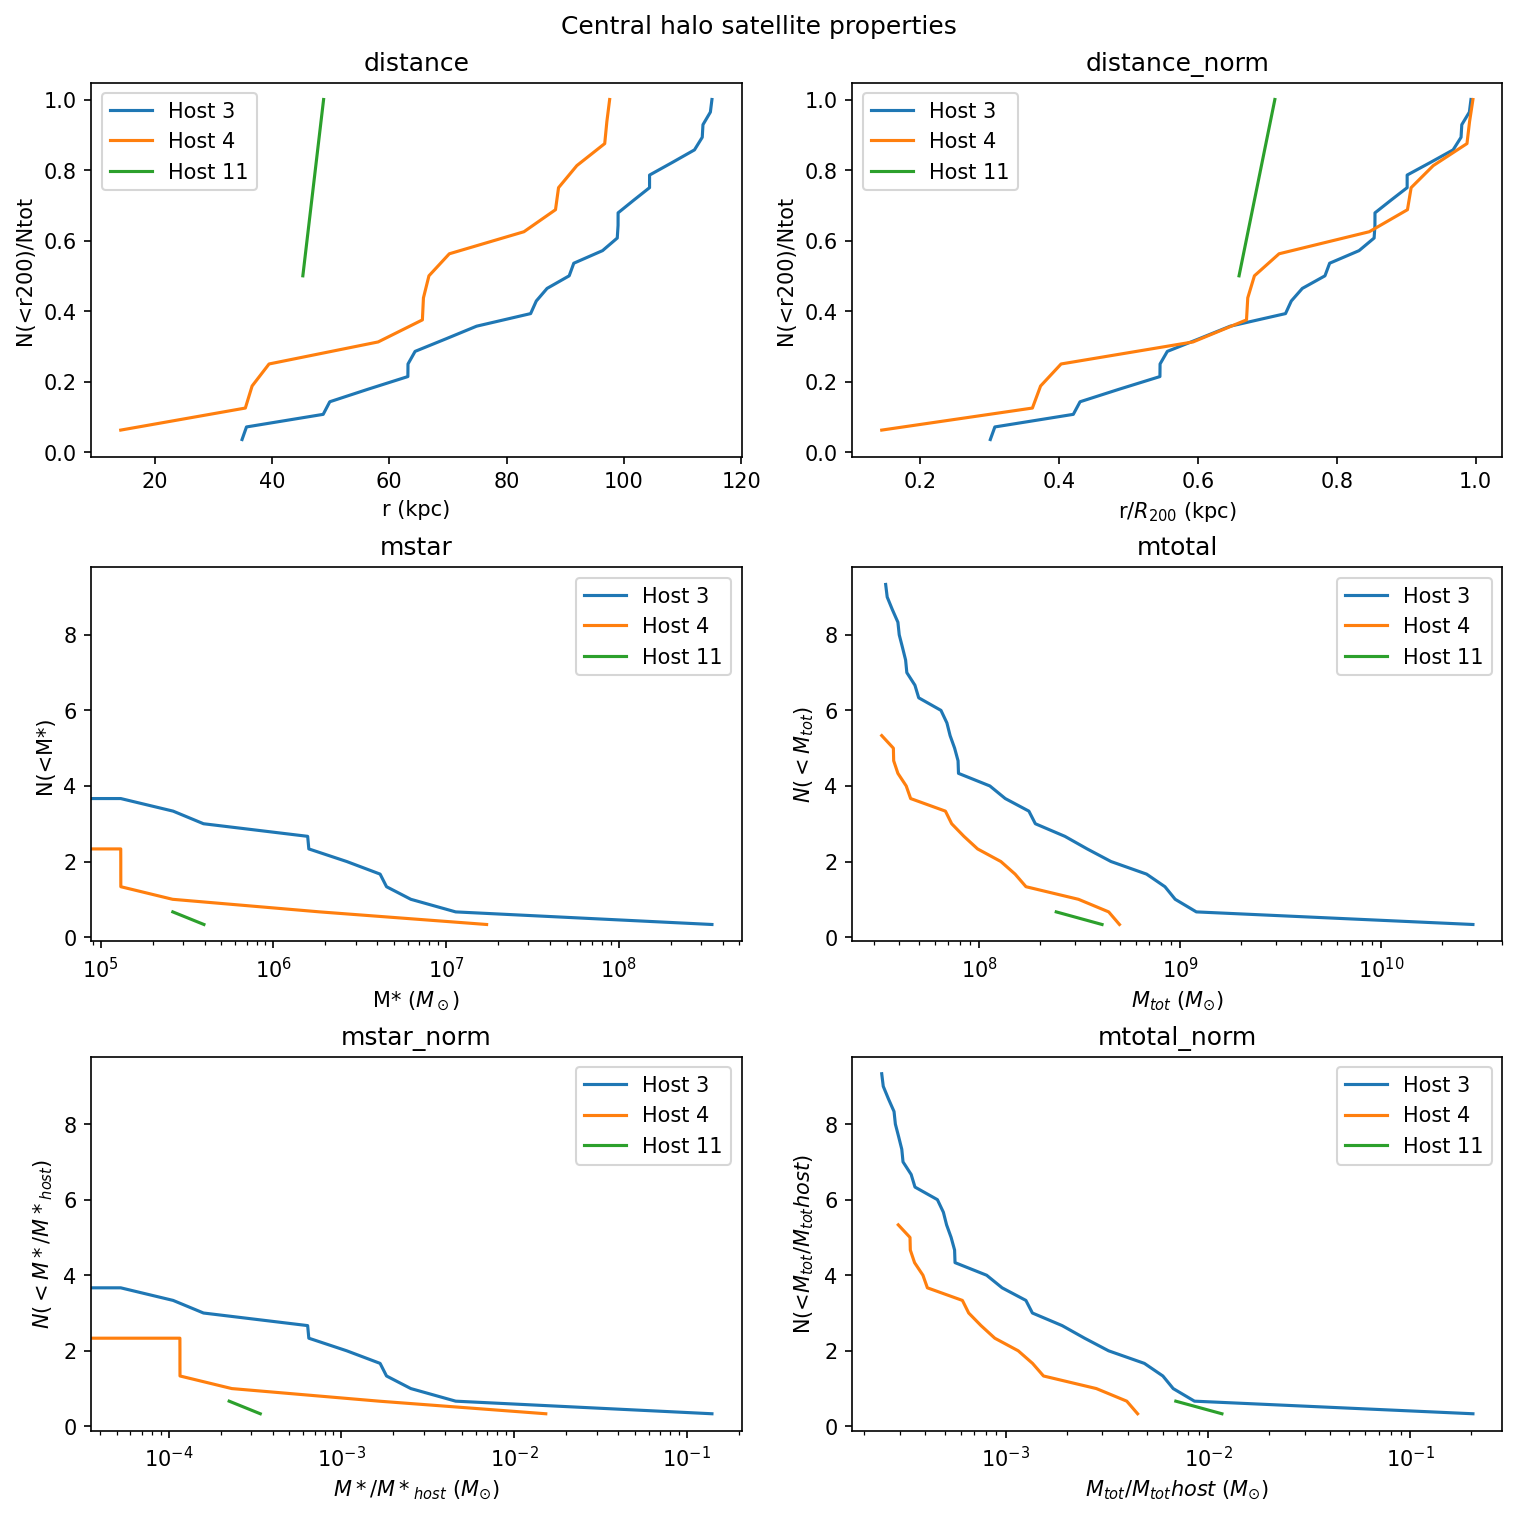

In [14]:
vol15_plotsim.number_plots(mstar_cut=True, mtot_cut=True)

In [15]:
vol15_plotsim.avg_number_plots(mstar_cut=False, mtot_cut=True)

TypeError: SimToolsPlotting.avg_number_plots() got an unexpected keyword argument 'distance_cut'

In [5]:
vol15_plotsim.central_df.loc[2]['Sat M*']/

[11367420.0,
 2659588.5,
 4521123.0,
 655515.6875,
 6252457.0,
 394113.15625,
 263551.8125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 268122.75,
 1579939.25,
 0.0,
 0.0,
 262258.25,
 0.0,
 262932.8125,
 0.0,
 0.0,
 0.0,
 261019.09375,
 0.0,
 0.0,
 0.0,
 0.0,
 1604724.375,
 130731.3359375,
 0.0,
 0.0,
 0.0,
 263192.96875,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 392740.65625,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 210790

In [ ]:
#Differentiate between the luminous and all satellites (always total mass cut)
def number_plots(self, distance_cut=True, mstar_cut=True, mtot_cut=False):        
    fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
    ax_flat = ax.flatten()
    
    #do mass cut of all satellite halos if mass_cut=True
    if mstar_cut==True:
        mstar_mask = [np.array(self.central_df['Sat M*'].loc[i])>1e5 for i in self.central_df['Host i']]
        for col in self.sat_cols:
            for i in range(len(mstar_mask)):
                self.central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mstar_mask[i]]
    if mtot_cut==True:
        mtot_mask = [np.array(self.central_df['Sat Mtot'].loc[i])>10**7.5 for i in self.central_df['Host i']]
        for col in self.sat_cols:
            for i in range(len(mtot_mask)):
                self.central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i]]

    for i in self.central_df['Host i']:
        r200 = self.central_df['Host R200'].loc[i]
        host_center = np.array(self.central_df['Host CoM'].loc[i])
        satellite_centers = self.central_df['Sat CoM'].loc[i]
        distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

        if distance_cut==True:
            # Distance cut of satellites
            distance_mask = distances < r200
            distances = distances[distance_mask]
            sat_mstar = np.array(self.central_df['Sat M*'].loc[i])[distance_mask]
            sat_mtot = np.array(self.central_df['Sat Mtot'].loc[i])[distance_mask]
        else:
            sat_mstar = self.central_df['Sat M*'].loc[i]
            sat_mtot = self.central_df['Sat Mtot'].loc[i]

        arrays = {
            'distance': distances,
            'distance_norm': distances / r200,
            'mstar': sat_mstar, 
            'mtotal': sat_mtot, 
            'mstar_norm': sat_mstar / self.central_df.loc[i]['Host M*'], 
            'mtotal_norm': sat_mtot / self.central_df.loc[i]['Host Mtot']
        }
        
        # Loop over the first 6 keys in the arrays dictionary
        for j, key in enumerate(list(arrays.keys())):
            # Get the x values and sort them in reverse order
            x_values = sorted(arrays[key], reverse=True)

            # Determine y values
            if key == 'distance' or key == 'distance_norm':
                y_values = np.linspace(len(x_values) + 1, 1, len(x_values))/len(x_values)
            else:
                ax_flat[j].set_xscale('log')
                y_values = np.arange(1, len(x_values) + 1)
                y_values = y_values/len(self.central_df)

            # Plot the values with a label for the host index
            host_id = self.central_df.loc[i]['Host ID']
            ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
            ax_flat[j].set_title(key)
            ax_flat[j].legend()

    ax_flat[0].set_xlabel('r (kpc)')
    ax_flat[0].set_ylabel('N(<r200)/Ntot')

    ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
    ax_flat[1].set_ylabel('N(<r200)/Ntot')

    ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
    ax_flat[2].set_ylabel('N(<M*)')
    #ax_flat[2].set_yscale('log')

    ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
    ax_flat[3].set_ylabel('$N(<M_{tot})$')
    #ax_flat[3].set_yscale('log')

    ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
    ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
    #ax_flat[4].set_yscale('log')

    ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
    ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
    #ax_flat[5].set_yscale('log')

    fig.suptitle('Central halo satellite properties')

    plt.show()

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:257: RuntimeWarning: divide by zero encountered in log10
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:258: RuntimeWarning: divide by zero encountered in log10


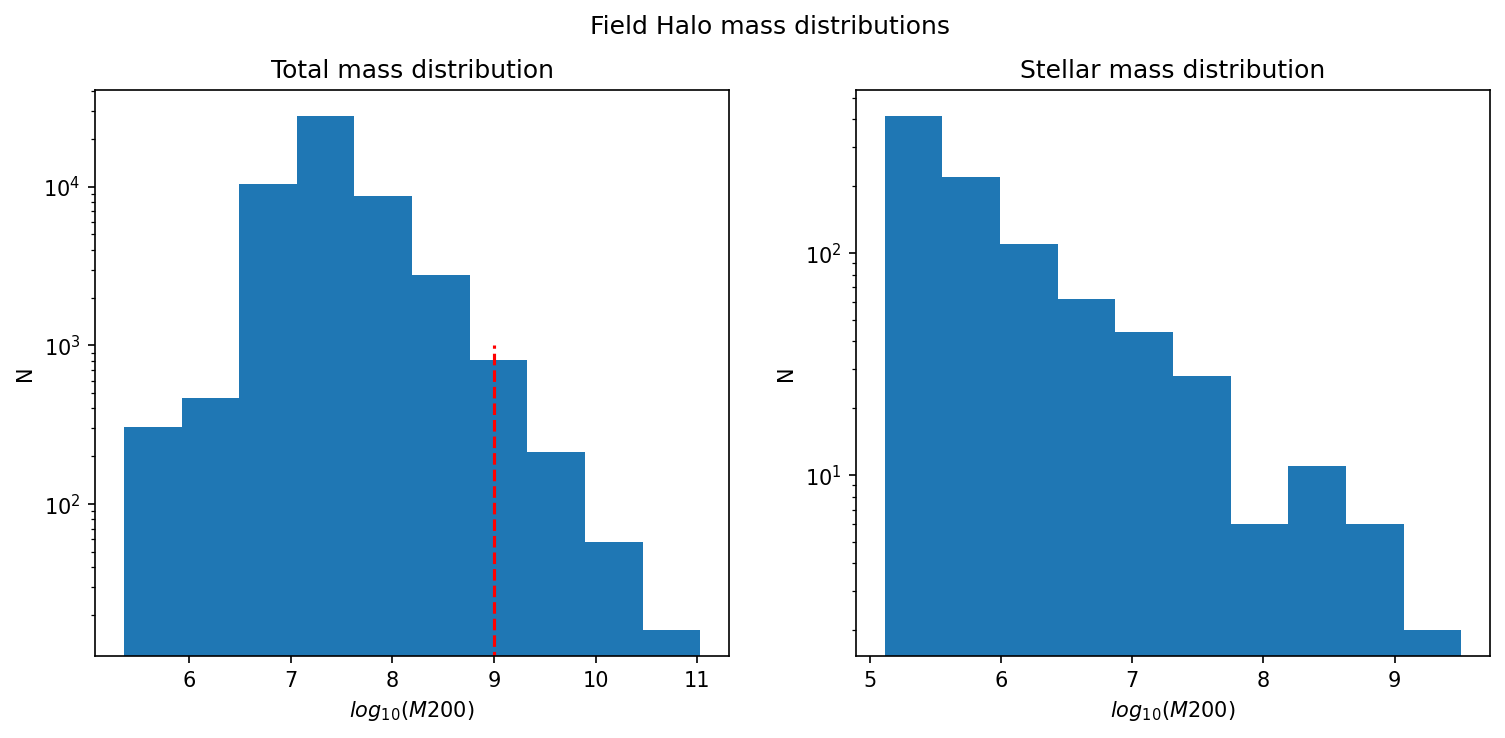

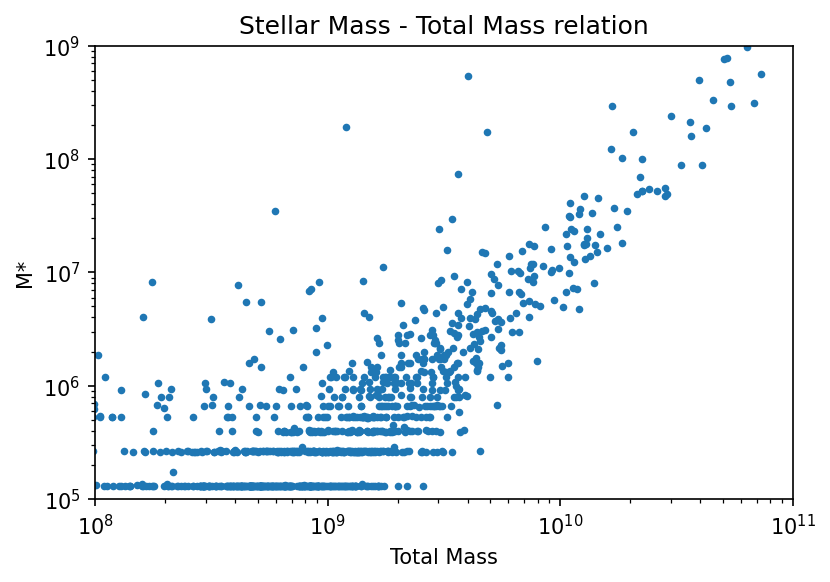

In [18]:
vol15_plotsim.plotFieldHaloMassDist()
vol15_plotsim.plotStellarMassHaloMass_all()

C:\Users\prera\AppData\Local\Temp\ipykernel_16644\2891400660.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


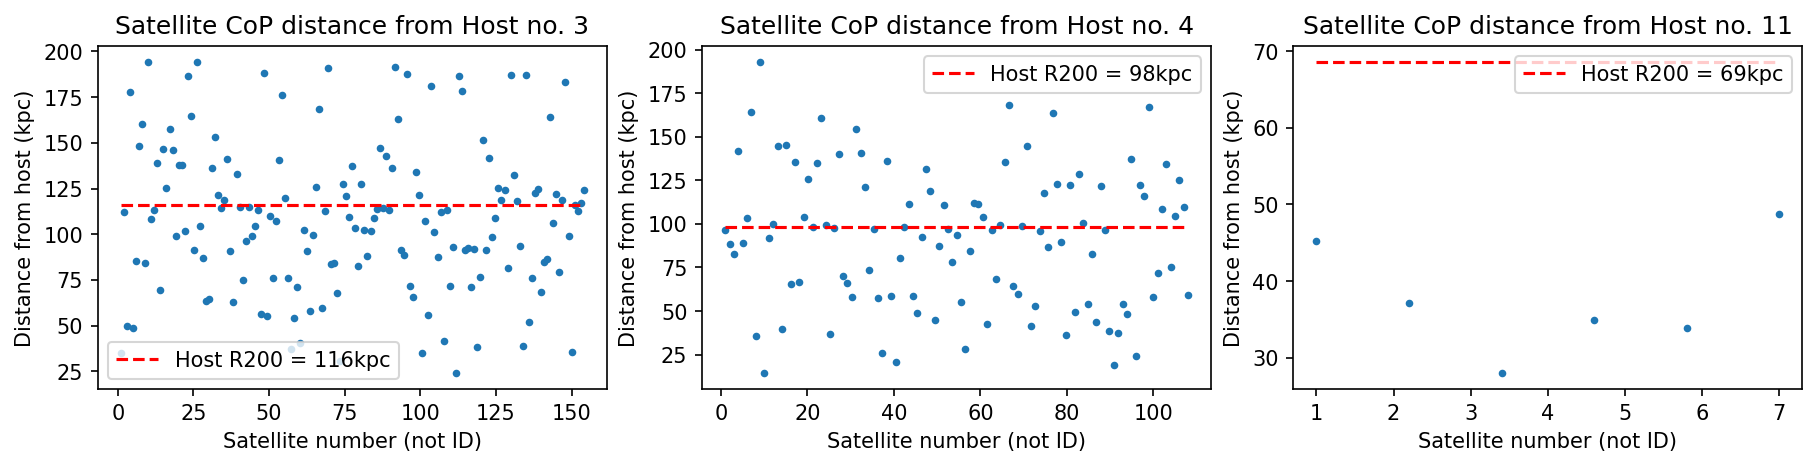

In [19]:
fig, ax = plt.subplots(1, len(vol15_df['Host ID']), figsize = (4*len(vol15_df['Host ID']), len(vol15_df['Host ID'])), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
central_centers = np.array(vol15_df['Host CoM'])
for i, host_center in enumerate(central_centers):
    sat_centers = np.array(vol15_df['Sat CoM'].iloc[i])
    distances = np.array([np.linalg.norm(sat-host_center) for sat in sat_centers])*1000 #in kpc
    x = np.linspace(1, len(distances)+1, len(distances)) 
    ax_flat[i].scatter(x, distances, s = 7)
    r200 = vol15_df['Host R200'].iloc[i]
    ax_flat[i].hlines(r200, min(x), max(x), 'r', '--', label = f'Host R200 = {r200:.0f}kpc')
    ax_flat[i].set_xlabel('Satellite number (not ID)')
    ax_flat[i].set_ylabel('Distance from host (kpc)')
    host_id = vol15_df['Host ID'].iloc[i]
    ax_flat[i].set_title(f'Satellite CoP distance from Host no. {host_id}')
    ax_flat[i].legend()
fig.show()

C:\Users\prera\AppData\Local\Temp\ipykernel_16644\293321340.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


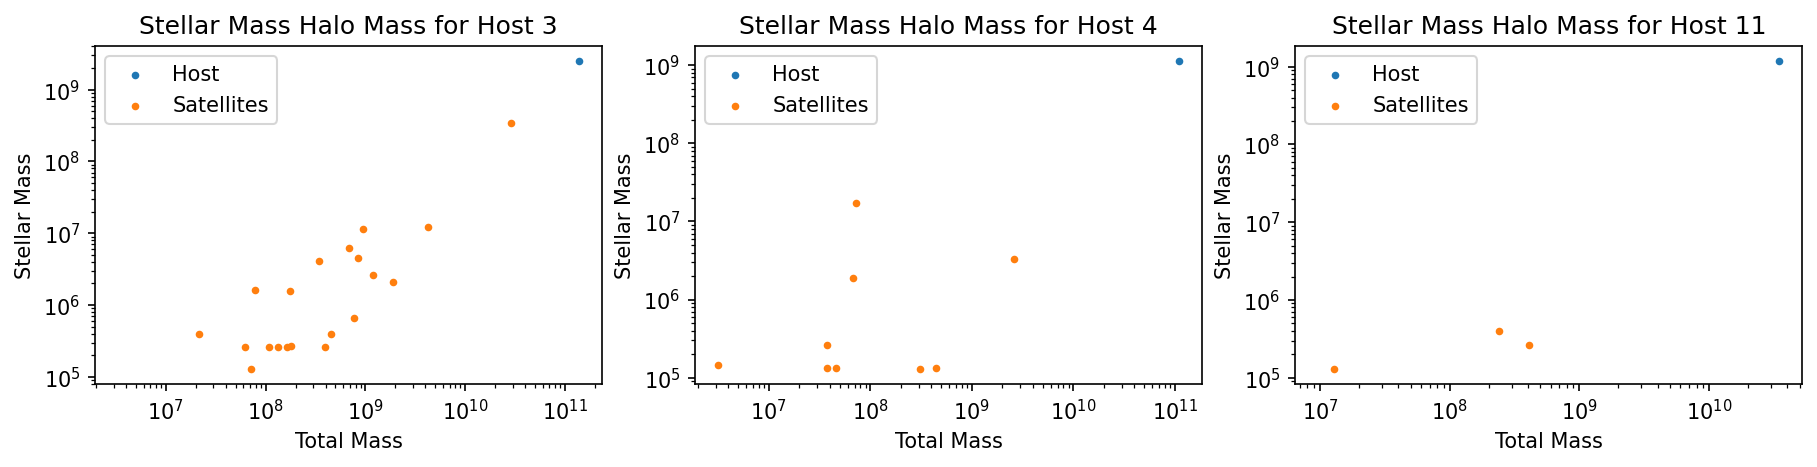

In [18]:
#make stellar mass hallo mass plots for each host and its respective satelites
#give satellites with no stellar mass some mass lower than 10^5
fig, ax = plt.subplots(1, len(vol15_df['Host ID']), figsize = (12, 3), dpi=150, constrained_layout=True)
for i, a in enumerate(ax):
    a.scatter(vol15_df['Host Mtot'].iloc[i], vol15_df['Host M*'].iloc[i], s=7, label='Host')
    a.scatter(vol15_df['Sat Mtot'].iloc[i], vol15_df['Sat M*'].iloc[i], s=7, label='Satellites')
    a.set_xlabel('Total Mass')
    a.set_ylabel('Stellar Mass')
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend()
    host_id = vol15_df['Host ID'].iloc[i]
    a.set_title(f'Stellar Mass Halo Mass for Host {host_id}')
fig.show()
#combine all three in one plot to compare diff hosts